In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
# Importing playlist dataframes
df = pd.read_csv('data/encoded_playlist_songs.csv')
df_fav = pd.read_csv('data/favorite_songs.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9769 entries, 0 to 9768
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          9769 non-null   object 
 1   name              9769 non-null   int64  
 2   album             9769 non-null   int64  
 3   artist            9769 non-null   int64  
 4   release_date      9769 non-null   int64  
 5   length            9769 non-null   int64  
 6   popularity        9769 non-null   int64  
 7   danceability      9769 non-null   float64
 8   acousticness      9769 non-null   float64
 9   energy            9769 non-null   float64
 10  instrumentalness  9769 non-null   float64
 11  liveness          9769 non-null   float64
 12  loudness          9769 non-null   float64
 13  speechiness       9769 non-null   float64
 14  tempo             9769 non-null   float64
 15  time_signature    9769 non-null   int64  
 16  favorite          9769 non-null   int64  


In [4]:
df_fav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          50 non-null     object 
 1   name              50 non-null     int64  
 2   album             50 non-null     int64  
 3   artist            50 non-null     int64  
 4   release_date      50 non-null     int64  
 5   length            50 non-null     int64  
 6   popularity        50 non-null     int64  
 7   danceability      50 non-null     float64
 8   acousticness      50 non-null     float64
 9   energy            50 non-null     float64
 10  instrumentalness  50 non-null     float64
 11  liveness          50 non-null     float64
 12  loudness          50 non-null     float64
 13  speechiness       50 non-null     float64
 14  tempo             50 non-null     float64
 15  time_signature    50 non-null     int64  
 16  favorite          50 non-null     int64  
dtyp

### Preparing data for model

In [5]:
df = pd.concat([df, df_fav], axis=0)
df.shape

(9819, 17)

In [6]:
X = df.drop(columns=['favorite', 'track_id'])
y = df.favorite
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X['favorite'] = y
X.head()

,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
0,4008,3340,581,2524,242096,90,0.586,0.1820,0.616,0.000000,0.0927,-7.964,0.0324,148.088,4,0
1,6038,212,3746,2293,215626,97,0.680,0.0212,0.826,0.000012,0.5430,-5.487,0.0309,118.051,4,0
2,8118,2222,1091,2505,165506,88,0.722,0.0319,0.588,0.000000,0.1830,-5.932,0.0544,134.010,4,0
3,3096,2743,1917,2524,170813,89,0.658,0.0106,0.634,0.000000,0.1320,-5.797,0.0413,139.980,4,0
4,542,433,2439,2478,132780,94,0.778,0.1750,0.695,0.000000,0.1500,-6.865,0.0913,149.996,4,0


In [7]:
X.shape

(19538, 16)

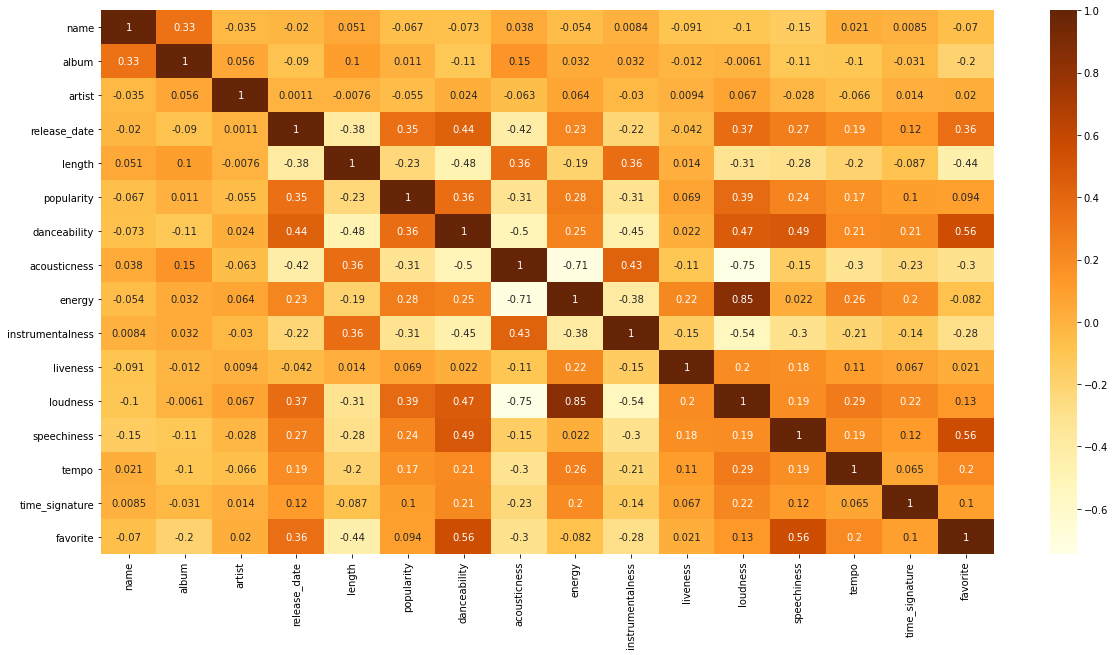

In [8]:
# Correlation Matrix of quantitative features
plt.figure(figsize=(20,10))
c = X.corr()
corr = sns.heatmap(c,cmap="YlOrBr",annot=True)

### Model Selection & Hyperparameter Tuning

In [9]:
# Importing required libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

In [10]:
# Train / Split Data
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='favorite'), X.favorite,test_size = .20)

In [11]:
X_train.shape

(15630, 15)

In [12]:
X_train.head()

,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
7884,4032,3477,1335,380,1011200,23,0.199,0.9580,0.0579,0.842000,0.4240,-21.315,0.0409,136.972,3
2994,1370,1291,210,2438,181280,33,0.495,0.0717,0.7680,0.000943,0.0638,-4.517,0.0508,101.140,4
2402,4437,7134,2725,963,152933,53,0.351,0.0337,0.3950,0.004540,0.1220,-8.745,0.0361,176.836,4
8851,3492,1531,782,1805,439797,0,0.241,0.9420,0.2210,0.884000,0.0559,-20.661,0.0423,134.477,4
3584,6054,5212,2117,2513,201653,55,0.602,0.7220,0.6620,0.000616,0.1040,-9.151,0.0406,159.965,4


### PCA on data

In [14]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
print(scaler.mean_)
print(scaler.scale_)

[ 4.12856935e+03  3.27832943e+03  2.13695809e+03  1.85769187e+03
  2.01348032e+05  4.29699296e+01  6.36388999e-01  2.74127817e-01
  5.27310249e-01  1.54450248e-01  1.79824140e-01 -1.02209027e+01
  1.55246696e-01  1.23317328e+02  3.92603967e+00]
[2.23205702e+03 2.07106935e+03 9.39593552e+02 6.51916957e+02
 1.33048722e+05 1.85859830e+01 1.95207368e-01 3.15505466e-01
 2.34501876e-01 2.96106712e-01 1.19989465e-01 5.97750071e+00
 1.25529444e-01 2.57769207e+01 3.44270521e-01]


In [17]:
X_scaled = scaler.transform(X_train)
X_scaled

array([[-0.04326473,  0.09592657, -0.85351596, ..., -0.91091534,
         0.52972471, -2.68986048],
       [-1.2358866 , -0.95956682, -2.05084219, ..., -0.83204938,
        -0.86035599,  0.21483202],
       [ 0.13818224,  1.86168106,  0.62584711, ..., -0.94915338,
         2.07622441,  0.21483202],
       ...,
       [ 0.80169576, -0.91514532,  0.63010427, ..., -0.59988555,
         0.8063281 ,  0.21483202],
       [ 1.00016739,  0.79121956, -0.0318841 , ..., -0.38607591,
         0.41803982,  0.21483202],
       [ 0.36443094,  0.3276909 , -1.00783801, ...,  0.22567394,
        -0.31042076,  0.21483202]])

#### Testing models

In [19]:
%%time
# Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=400)
lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
print(np.mean(lr_scores))

0.8264086973941825
CPU times: user 3.75 s, sys: 1.25 s, total: 5 s
Wall time: 1.47 s


In [20]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [21]:
%%time
# Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=5)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

CPU times: user 896 ms, sys: 17.2 ms, total: 913 ms
Wall time: 923 ms


0.9634469012267918

In [22]:
%%time
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[3, 6,12,15,20],
    'n_estimators':[10, 20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(X_train, y_train)
clf.named_steps['CV'].best_params_

CPU times: user 25.6 s, sys: 235 ms, total: 25.9 s
Wall time: 26 s


{'max_depth': 20, 'n_estimators': 30}

In [23]:
%%time
# RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 20))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

CPU times: user 5.26 s, sys: 55.2 ms, total: 5.31 s
Wall time: 5.37 s


0.9985982369508651

Since the RandomForestClassifier has the highest accuracy, I will use it to recommend songs.

In [17]:
rf_test_scores = cross_val_score(rf, X_test, y_test, cv=10, scoring="f1")
np.mean(rf_test_scores)

0.9820513383646929

In [20]:
rf.fit(X_train, y_train)
prediction = rf.predict(X_train)
len(prediction)

15630

## Predicting songs and saving to dataset

In [21]:
df['prediction'] = prediction

ValueError: Length of values (15630) does not match length of index (9819)

## Building the playlist from recommended songs

In [ ]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [ ]:
create_playlist(sp, username, 'Your New Jams', 'This playlist was created using python!')

In [ ]:
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [ ]:
fetch_playlists(sp,username).head()

In [ ]:
playlist_id = fetch_playlists(sp,username)['id'][0]

In [ ]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 50])
        index += 50

In [ ]:
list_track = df2.index
enrich_playlist(sp, username, playlist_id, list_track)
fetch_playlists(sp,username).head()